In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn
import time
import pickle

import patsy
%matplotlib inline
plt.style.use('seaborn')

In [13]:
%time
df = pd.read_csv('Taxi_Trips_NearSouth_Updated.csv')

CPU times: user 4 µs, sys: 7 µs, total: 11 µs
Wall time: 35 µs


In [14]:
df.shape

(2204222, 18)

In [17]:
df.head(5)

,Trip Start Timestamp,Trip Seconds,Trip Miles,Pickup Community Area,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
0,01/01/2013 12:00:00 AM,360.0,2.3,33,7.85,0.0,0.0,2.0,9.85,41.859350,-87.617358,41.884987,-87.620993
1,01/01/2013 12:00:00 AM,480.0,0.0,33,7.65,1.0,0.0,1.0,9.65,41.859350,-87.617358,41.880994,-87.632746
2,01/01/2013 12:00:00 AM,1200.0,3.7,33,13.45,0.0,0.0,1.5,14.95,41.859350,-87.617358,41.898332,-87.620763
3,01/01/2013 12:00:00 AM,60.0,0.3,33,3.65,0.0,0.0,1.0,4.65,41.859350,-87.617358,41.859350,-87.617358
4,01/01/2013 12:00:00 AM,900.0,0.0,33,10.65,0.0,0.0,2.0,12.65,41.857184,-87.620335,41.899602,-87.633308


In [16]:
df = df.drop(['Trip ID','Taxi ID','Trip End Timestamp','Dropoff Community Area','Payment Type'],axis=1)

In [18]:
%time
# Change datetime format for trip start and remove original timestamp 
df['Trip_Start'] = pd.to_datetime(df['Trip Start Timestamp'])
df.drop('Trip Start Timestamp',axis=1, inplace=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


In [94]:
dfn = df.copy()

In [95]:
dfn['month'] = dfn.Trip_Start.dt.month
dfn['time'] = dfn.Trip_Start.dt.time
dfn['day']=dfn.Trip_Start.dt.dayofweek
dfn = dfn.drop('Trip_Start', axis=1)

In [96]:
dfn = dfn.drop(['Pickup Centroid Latitude','Pickup Centroid Longitude','Dropoff Centroid Latitude','Dropoff Centroid Longitude'],axis=1)

In [97]:
dfn.drop('Pickup Community Area', axis=1, inplace=True)

In [108]:
dfn.head(5)

,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Trip Total,month,time,Day,season,rate
0,360.0,2.3,7.85,0.0,0.0,2.0,9.85,1,00:00:00,Tuesday,Winter,0.027361
1,480.0,0.0,7.65,1.0,0.0,1.0,9.65,1,00:00:00,Tuesday,Winter,0.020104
2,1200.0,3.7,13.45,0.0,0.0,1.5,14.95,1,00:00:00,Tuesday,Winter,0.012458
3,60.0,0.3,3.65,0.0,0.0,1.0,4.65,1,00:00:00,Tuesday,Winter,0.077500
4,900.0,0.0,10.65,0.0,0.0,2.0,12.65,1,00:00:00,Tuesday,Winter,0.014056


In [107]:
dfn.drop('day', axis=1, inplace=True)

In [100]:
# Create a Day column
def day_convert(row):
    if row['day'] == 0:
        val = 'Monday'
    elif row['day'] == 1:
        val = 'Tuesday'
    elif row['day'] == 2:
        val = 'Wednesday'
    elif row['day'] == 3:
        val = 'Thursday'
    elif row['day'] == 4:
        val = 'Friday'
    elif row['day'] == 5:
        val = 'Saturday'
    else:
        val = 'Sunday'
    return val
dfn['Day'] = dfn.apply(day_convert, axis=1)

In [104]:
# create a season column
def f(row):
    if row['month'] in (12, 1, 2):
        val = 'Winter'
    elif row['month'] in [3,4,5]:
        val = 'Spring'
    elif row['month'] in [6,7,8]:
        val = 'Summer'
    else:
        val = 'Fall'
    return val

dfn['season'] = dfn.apply(f, axis=1)

In [105]:
dfn['rate']=dfn['Trip Total']/dfn['Trip Seconds']

In [109]:
gcol = ['Day','month','time','season']
df_analysis = dfn.groupby(gcol).aggregate({
    'Trip Miles':'count',
    'Trip Total':'mean',
    'Trip Seconds': 'mean',
    'rate': 'mean'
}).reset_index()

In [112]:
df_analysis.head(5)

,Day,time,season,Trip Miles,Trip Total,Trip Seconds,rate
0,Friday,00:00:00,Winter,73,10.640959,580.273973,inf
1,Friday,00:15:00,Winter,72,11.875833,660.000000,inf
2,Friday,00:30:00,Winter,77,10.631299,548.636364,inf
3,Friday,00:45:00,Winter,58,10.751552,543.103448,inf
4,Friday,01:00:00,Winter,55,12.593455,682.272727,inf


In [119]:
df_analysis.drop('time',axis=1,inplace=True)

In [116]:
df_analysis.rename(columns={'Trip Miles':'Count_Trips'},inplace=True)

In [117]:
df_analysis['num_minutes'] = df_analysis['time'].transform(lambda dt: dt.hour*60 + dt.minute)

In [120]:
df_analysis.head(5)

,Day,season,Count_Trips,Trip Total,Trip Seconds,rate,num_minutes
0,Friday,Winter,73,10.640959,580.273973,inf,0
1,Friday,Winter,72,11.875833,660.000000,inf,15
2,Friday,Winter,77,10.631299,548.636364,inf,30
3,Friday,Winter,58,10.751552,543.103448,inf,45
4,Friday,Winter,55,12.593455,682.272727,inf,60


In [121]:
# make day, and season categorical variables 
season_c=patsy.dmatrix('season',data=df_analysis,return_type='dataframe')
day_c=patsy.dmatrix('Day',data=df_analysis,return_type='dataframe')

In [123]:
df_analysis1=df_analysis.join(season_c)

In [131]:
df_analysis.drop(['Day','season'],axis=1, inplace=True)

In [127]:
df_analysis=df_analysis1.join(day_c)

In [4]:
df_analysis.head(5)

,Count_Trips,Trip Total,Trip Seconds,rate,num_minutes,season[T.Spring],season[T.Summer],season[T.Winter],Day[T.Monday],Day[T.Saturday],Day[T.Sunday],Day[T.Thursday],Day[T.Tuesday],Day[T.Wednesday]
0,73,10.640959,580.273973,inf,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72,11.875833,660.000000,inf,15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,77,10.631299,548.636364,inf,30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58,10.751552,543.103448,inf,45,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55,12.593455,682.272727,inf,60,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# open the pickle file
with open ('df_analysis_South.pkl', 'rb') as file:
    df_analysis = pickle.load(file)

In [3]:
df_analysis.head(5)

,Count_Trips,Trip Total,Trip Seconds,rate,num_minutes,season[T.Spring],season[T.Summer],season[T.Winter],Day[T.Monday],Day[T.Saturday],Day[T.Sunday],Day[T.Thursday],Day[T.Tuesday],Day[T.Wednesday]
0,73,10.640959,580.273973,inf,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,72,11.875833,660.000000,inf,15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,77,10.631299,548.636364,inf,30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,58,10.751552,543.103448,inf,45,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55,12.593455,682.272727,inf,60,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_analysis.to_pickle('df_analysis_South.pkl')

## Time Series Analysis

In [32]:
import requests
from io import BytesIO
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


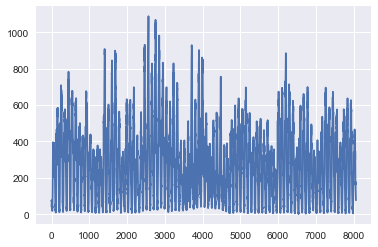

In [30]:
df_analysis.Count_Trips.plot()

In [31]:
print(df_analysis.Count_Trips.std())
print(df_analysis.Count_Trips.diff().std()) # lowest, we should difference once
print(df_analysis.Count_Trips.diff().diff().std())
print(df_analysis.Count_Trips.diff().diff().diff().std())

213.76688954428968
33.258954058384845
47.378648963603204
85.41406866255684


Figure(432x288)
Figure(432x288)


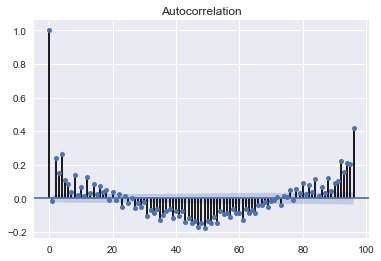

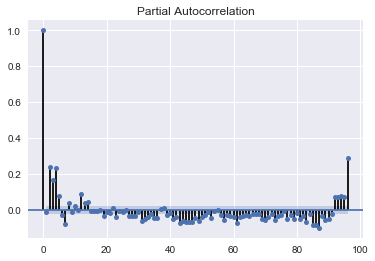

In [37]:
plt.figure(dpi=200)
print(plot_acf(df_analysis.Count_Trips.diff()[1:], lags=4*24)) 
print(plot_pacf(df_analysis.Count_Trips.diff()[1:], lags=4*24))

In [40]:
# Add columns of 5 previous periods, future period, and a day prior
df_analysis['L'] = df_analysis.shift(1).Count_Trips
df_analysis['2L'] = df_analysis.shift(2).Count_Trips
df_analysis['3L'] = df_analysis.shift(3).Count_Trips
df_analysis['4L'] = df_analysis.shift(4).Count_Trips
df_analysis['5L'] = df_analysis.shift(5).Count_Trips
df_analysis['-L'] = df_analysis.shift(-1).Count_Trips
df_analysis['D'] = df_analysis.shift(96).Count_Trips

In [45]:
# Drop the NaN's 
df_analysis.dropna(inplace=True)

In [47]:
df_analysis.head(5)

,Count_Trips,Trip Total,Trip Seconds,rate,num_minutes,season[T.Spring],season[T.Summer],season[T.Winter],Day[T.Monday],Day[T.Saturday],...,Day[T.Thursday],Day[T.Tuesday],Day[T.Wednesday],L,2L,3L,4L,5L,-L,D
96,67,12.308209,582.895522,inf,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,143.0,148.0,168.0,183.0,169.0,70.0,73.0
97,70,14.186143,668.571429,inf,15,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,67.0,143.0,148.0,168.0,183.0,44.0,72.0
98,44,11.291136,572.727273,inf,30,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,70.0,67.0,143.0,148.0,168.0,57.0,77.0
99,57,12.902807,645.263158,inf,45,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,44.0,70.0,67.0,143.0,148.0,41.0,58.0
100,41,12.457317,671.707317,inf,60,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,57.0,44.0,70.0,67.0,143.0,54.0,55.0


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [48]:
# Scale data
ssX = StandardScaler()

X = df_analysis[[x for x in df_analysis.columns if (x!='Trip Total' and x!='Trip Seconds' and x!='rate' and x!='Count_Trips')]]
y1 = df_analysis['Count_Trips']
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.2, random_state=42)

X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

In [6]:
def train_scores(lr):
    kfold = KFold(n_splits=5)
    results = {
        'train': [],
        'validation': []
    }
    for train_indicies, test_indicies in kfold.split(X_train_scaled):
        lr.fit(X_train_scaled[train_indicies], y1_train.values[train_indicies])
        predictions = lr.predict(X_train_scaled[train_indicies])
        train_score = np.mean(-abs(predictions - y1_train.values[train_indicies]))
        
        predictions = lr.predict(X_train_scaled[test_indicies])
        val_score = np.mean(-abs(predictions - y1_train.values[test_indicies]))
        
        results['train'].append(train_score)
        results['validation'].append(val_score)
        
    return results

## Build a model on demand

In [49]:
model1 = LinearRegression()
model1.fit(X_train_scaled, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
from sklearn.dummy import DummyRegressor

In [51]:
print("RSquared Score is: ", str(model1.score(X_train_scaled,y1_train)))
print("The training score is: " + str(sum(train_scores(model1)["train"])/len(train_scores(model1)["train"])))
print("The validation score is: " + str(sum(train_scores(model1)["validation"])/len(train_scores(model1)["validation"])))

RSquared Score is:  0.9885475113221031
The training score is: -16.17642556869336
The validation score is: -16.225790314509958


In [52]:
dummy = DummyRegressor()
dummy.fit(X_train_scaled, y1_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [53]:
yd_predict = dummy.predict(X_test_scaled)

In [54]:
np.sqrt(mean_squared_error(y1_test, yd_predict))

213.0357315988866

In [55]:
y1_predict = model1.predict(X_test_scaled)

In [56]:
np.sqrt(mean_squared_error(y1_test, y1_predict))

23.086056246027557

## Build a model on total dollar

In [57]:
y2 = df_analysis['Trip Total']
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size = 0.2, random_state=42)

In [58]:
model2 = LinearRegression()
model2.fit(X_train_scaled, y2_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
ym_predict = model2.predict(X_test_scaled)

In [60]:
print("RSquared Score is: ", str(model2.score(X_train_scaled,y2_train)))

RSquared Score is:  0.0530177054654255


In [61]:
model2.score(X_test_scaled, y2_test)

0.09380834764315171

In [62]:
print("The training score is: " + str(sum(train_scores(model2)["train"])/len(train_scores(model2)["train"])))

The training score is: -16.17642556869336


In [63]:
np.sqrt(mean_squared_error(y2_test, ym_predict))

3.8346274281791253

## Demand using polynomial features

In [64]:
degree=2
model1a = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model1a.fit(X_train_scaled, y1_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [65]:
yd1a_predict = model1a.predict(X_test_scaled)

In [66]:
print("RSquared Score is: ", str(model1a.score(X_train_scaled,y1_train)))
print("The training score is: " + str(sum(train_scores(model1a)["train"])/len(train_scores(model1a)["train"])))
print("The validation score is: " + str(sum(train_scores(model1a)["validation"])/len(train_scores(model1a)["validation"])))

RSquared Score is:  0.9899326913282996
The training score is: -15.653190806018605
The validation score is: -16.21148750216738


In [67]:
np.sqrt(mean_squared_error(y1_test, yd1a_predict))

22.37847871409507

## Try GridSearch

In [69]:
%time
degree=2
model1b = make_pipeline(PolynomialFeatures(degree), Ridge(max_iter = 1000))
parameters = {'ridge__alpha':[1,3]}
grid = GridSearchCV(model1b, parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train_scaled, y1_train)

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 26 µs


Process ForkPoolWorker-47:
Process ForkPoolWorker-45:
Process ForkPoolWorker-46:


KeyboardInterrupt: 